# ResOpsMX: time series
***

**Autor:** Chus Casado<br>
**Date:** 05-08-2024<br>

**Introduction:**<br>
This code creates the time series for the reservoirs in ResOpsMX. The time series include records from ResOpsUS and simulations from GloFAS.

The result is a time series that combines the observed data from ResOpsUS with the simulation from GloFASv4 (when possible). For each reservoir, these time series are exported both in CSV and a NetCDF format.

Records are cleaned to avoid errors:
    * Outliers in the **storage** time series are filtered by comparison with the a moving median (window 7 days). If the relative difference of a given storage value and the moving median exceeds a threshold, the value is removed. This procedure is encapsulated in the function `lisfloodreservoirs.utils.timeseries.clean_storage()`
    * Outliers in the **inflow** time series are removed using two conditions: one based in the gradient, and the other using an estimated inflow based on the water balance. When both conditions are met, the value is removed. Since inflow time series cannot contain missing values when used in the reservoir simulation, a simple linear interpolation is used to fill in gaps up to 7 days. This procedure is encapsulated in the function `lisfloodreservoirs.utils.timeseries.clean_inflow()`.

**To do:**<br>
* [ ] 8 reservoirs that should be in GloFAS don't have time series.
* [ ] Plot time series
* [ ] Make sure that there aren't negative values in the time series, nor zeros in storage.
* [ ] Check the quality of the data by closing the mass balance when possible. <font color='steelblue'>I've used the mass balance to identify errors in the inflow time series (function `clean_inflow`).</font>.
* [ ] Fill in the inflow time series with the mass balance, if possible. <font color='steelblue'>I've filled in gaps in the inflow time series with linear interpolation up to 7-day gaps (function `clean_inflow`).</font>.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import yaml
from pathlib import Path
from tqdm.auto import tqdm
from copy import deepcopy

from lisfloodreservoirs import read_attributes
from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis, compare_flows
from lisfloodreservoirs.utils.timeseries import clean_storage, clean_inflow

In [2]:
import matplotlib.pyplot as plt

## Configuration

In [3]:
with open('config_dataset.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

VERSION = cfg['version']

#paths
PATH_RESOPS = Path(cfg['paths']['dataset']['root'])
# PATH_GLOFAS = Path(cfg['paths']['GloFAS']['root'])
PATH_GRAND = Path(cfg['paths']['GRanD'])

# conditions to consider a reservoir in the ResOpsES dataset
MIN_AREA = cfg['conditions'].get('min_area', None) # km2
MIN_VOL = cfg['conditions'].get('min_volume', None) # hm3

# period
START = pd.to_datetime(cfg['period']['start'])
END = pd.to_datetime(cfg['period']['end'])

# path where results will be saved
PATH_OUT = PATH_RESOPS / VERSION / 'time_series'
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=True, exist_ok=True)
print(f'Time series will be saved in {PATH_OUT}')

Time series will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsMX\v1.0\time_series


## Data

### Attributes


In [4]:
# import all tables of attributes
attributes = read_attributes(PATH_RESOPS / VERSION / 'attributes')
map_key_grand = {key: grand_id for grand_id, key in attributes['KEY'].iteritems()}

print(f'{attributes.shape[0]} reservoirs in the attribute tables')

99 reservoirs in the attribute tables


In [10]:
dams = attributes[['LAT', 'LON', 'CATCH_SKM']]
dams.index.name = 'ID'
dams.columns = ['lat', 'lon', 'area']

dams.to_csv('dams.csv')
dams

,lat,lon,area
ID,,,
672,32.479444,-116.696944,111
673,32.444722,-116.908333,2798
675,30.873333,-111.516389,2278
676,30.437778,-109.378889,18786
677,29.212500,-110.725556,11753
...,...,...,...
1390,16.445556,-95.397778,9545
1391,16.401389,-92.778889,18331
1392,15.996389,-92.898611,610


### Time series
#### ResOpsES

In [40]:
# read time series
timeseries = {}
for key, grand_id in tqdm(map_key_grand.items()):
    file = PATH_RESOPS / 'raw' / 'time_series' / f'{key}.csv'
    if file.is_file():
        ts = pd.read_csv(file, parse_dates=['date'], index_col='date')
        # rename columns
        rename_cols = {
            'A_HA': 'area',
            'V_MCM': 'storage',
            'Z_MASL': 'elevation',
            'PRECIP_MM': 'precipitation',
            'EVAP_MM': 'evaporation'
        }
        ts.rename(columns=rename_cols, inplace=True)
        # clean outliers in storage
        clean_storage(ts.storage, w=7, error_thr=.2, inplace=True)
        # convert area to km²
        ts.area /= 100
        # add outflows
        ts['outflow'] = np.nansum(ts[['SLUICE_CMS', 'SPILL_CMS']], axis=1)
        # trim time series to period with storage and outflow
        mask_availability = ts[['storage', 'outflow']].notnull().all(axis=1)
        start, end = ts[mask_availability].first_valid_index(), ts[mask_availability].last_valid_index()
        start, end = max(START, start), max(END, end) # end could be the min() instead
        ts = ts.loc[start:end]
        # remove negative values
        ts[ts < 0] = np.nan
        # save
        timeseries[grand_id] = ts.loc[start:end]
    else:
        print(f'File not found: {file}')
    
print(f'Time series were imported for {len(timeseries)} reservoirs')

  0%|          | 0/99 [00:00<?, ?it/s]

Time series were imported for 99 reservoirs


In [41]:
lw = 1
labels = ['GRanD', 'MX']
linestyles = [':', '--']

for grand_id, ts in timeseries.items():
    
    fig, axes = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

    ax1 = axes[0]
    ax1.plot(ts.storage, c='C0', lw=lw, label='obs')
    for col, label, ls in zip(['CAP_MCM', 'NAME_MCM'], labels, linestyles):
        ax1.axhline(attributes.loc[grand_id, col], c='C0', ls=ls, lw=lw*.5, label=label)
    ax1.set_ylim(0, None)
    ax1.set_ylabel('storage (hm3)', color='C0')

    # ax2 = ax1.twinx()
    # ax2.plot(ts.A_HA * 1e-2, c='C2', lw=lw)
    # ax2.axhline(attributes.loc[grand_id, 'AREA_SKM'], c='C1', ls=':', lw=.5)
    # ax2.set_ylim(0, None)
    # ax2.set_ylabel('area (km²)', color='C1');

    ax2 = ax1.twinx()
    ax2.plot(ts.elevation, c='C1', lw=lw, label='obs')
    for col, label, ls in zip(['ELEV_MASL', 'NAME_MASL'], labels, linestyles):
        ax2.axhline(attributes.loc[grand_id, col], c='C1', ls=ls, lw=lw*.5, label=label)
    ax2.set_ylim(attributes.loc[grand_id, 'NAME_MASL'] - attributes.loc[grand_id, 'DAM_HGT_M'] * 1.2, None)
    ax2.set_ylabel('elevation (masl)', color='C1');

    ax = axes[1]
    ts[['SLUICE_CMS', 'SPILL_CMS']].plot(ax=ax, lw=lw)
    ax.set(ylabel='m3/s');

    ax = axes[2]
    ts[['precipitation', 'evaporation']].plot(lw=1, ax=ax)
    ax.set(ylabel='mm');
    
    # title
    axes[0].text(.5, 1.075, '{0} - {1}'.format(grand_id, attributes.loc[grand_id, 'RES_NAME']),
                 ha='center', fontsize=12, transform=axes[0].transAxes);

    plt.savefig(PATH_PLOTS / f'{grand_id}.jpg', dpi=300, bbox_inches='tight');
    plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(ts.area, ts.storage, s=1, c=ts.index, cmap='Greys')
ax.set(xlabel='area (km²)',
       ylabel='storage (hm3)');

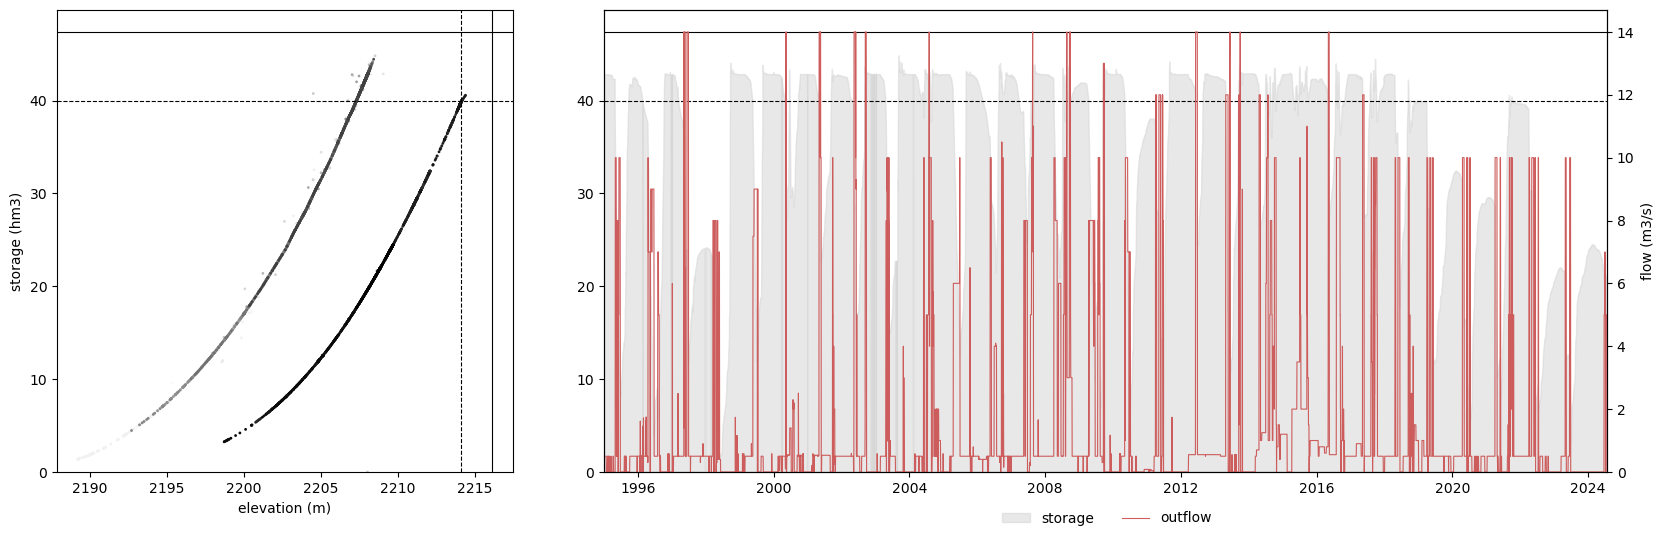

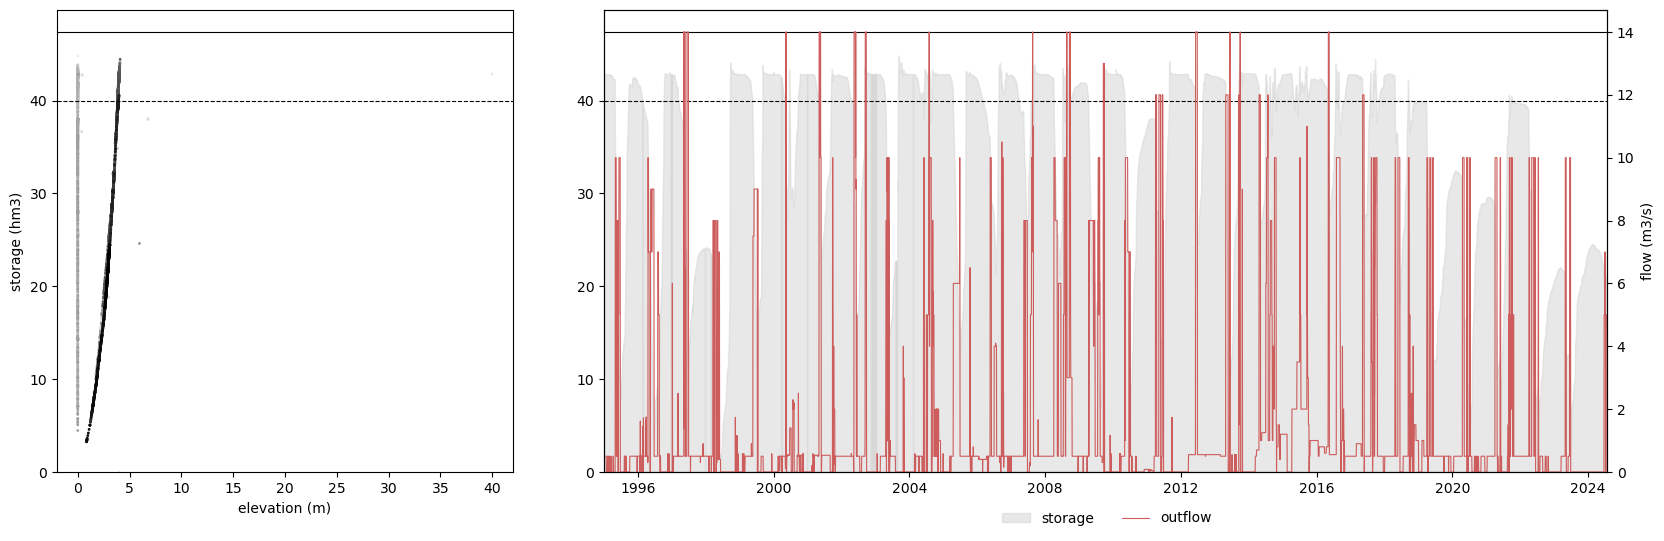

In [36]:
grand_id = 1363 #1349 #1347 #1333
ts = timeseries[grand_id]

plot_resops(ts.storage, ts.elevation, outflow=ts.outflow,
            capacity=attributes.loc[grand_id, ['NAME_MCM', 'NAMO_MCM']],
            level=attributes.loc[grand_id, ['NAME_MASL', 'NAMO_MASL']])

plot_resops(ts.storage, ts.area, outflow=ts.outflow,
            capacity=attributes.loc[grand_id, ['NAME_MCM', 'NAMO_MCM']],
            # level=attributes.loc[grand_id, ['NAME_MASL', 'NAMO_MASL']]
           )

In [37]:
foo = clean_storage(ts.storage, error_thr=.2)

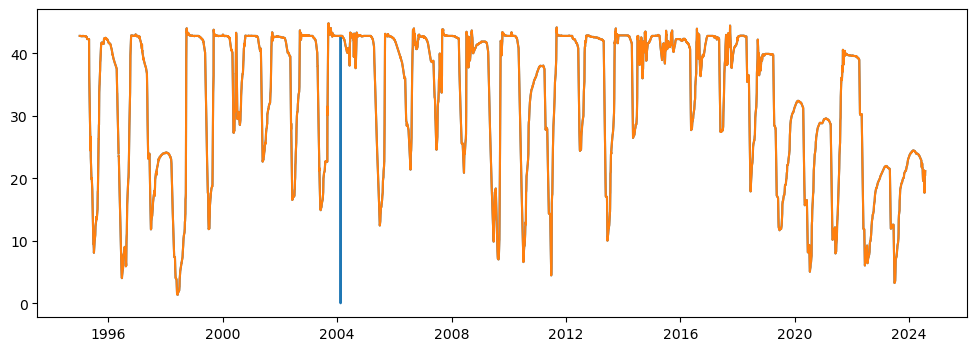

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts.storage)
ax.plot(foo);

In [ ]:
timeseries[grand_id].last_valid_index()

In [ ]:
path_plots = PATH_OUT / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
resops_ts = {}
for grand_id in tqdm(attributes.index, desc='Reading observed time series'): # ID refers to GRanD
    # load timeseries
    file = PATH_OBS_TS / f'ResOpsUS_{grand_id}.csv'
    if file.is_file():
        series = pd.read_csv(file, parse_dates=True, index_col='date')
    else:
        print(f"{file} doesn't exist")
    # trim to GloFAS long run period
    series = series.loc[START:END]
    # remove duplicated index
    series = series[~series.index.duplicated(keep='first')]
    # remove negative values
    series[series < 0] = np.nan
    # clean storage time series
    series.storage = clean_storage(series.storage, w=7, error_thr=0.1)
    # clean inflow time series
    series.inflow = clean_inflow(series.inflow, 
                                 storage=series.storage if attributes.loc[grand_id, 'STORAGE'] == 1 else None, 
                                 outlfow=series.outflow if attributes.loc[grand_id, 'OUTFLOW'] == 1 else None, 
                                 grad_thr=1e4, 
                                 balance_thr=5, 
                                 int_method='linear')
    # save in dictionary
    resops_ts[grand_id] = series

    # plot observed time series
    plot_resops(series.storage,
                series.elevation,
                series.inflow,
                series.outflow,
                attributes.loc[grand_id, ['CAP_MCM', 'CAP_GLWD']].values,
                title=grand_id,
                save=path_plots / f'{grand_id:04}_lineplot.jpg'
               )

print(f'{len(resops_ts)} reservoirs in ResOpsUS time series')

In [ ]:
# convert to xarray.Dataset
xarray_list = []
for key, df in resops_ts.items():
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.assign_coords(GRAND_ID=key)
    xarray_list.append(ds)
obs = xr.concat(xarray_list, dim='GRAND_ID')

#### GloFAS

In [ ]:
# import time series
glofas_ts = {}
mask = ~attributes.GLOFAS_ID.isnull()
for grand_id, glofas_id in tqdm(attributes[mask].GLOFAS_ID.iteritems(), total=mask.sum(), desc='Reading simulated time series'):
    file = PATH_SIM_TS / f'{glofas_id:03.0f}.csv'
    if file.is_file():
        series = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
        series.index -= timedelta(days=1)
        series.storage *= attributes.loc[grand_id, 'CAP_GLWD']
        series[series < 0] = np.nan
        # series.columns = [f'{col.lower()}_glofas' for col in series.columns]
        glofas_ts[grand_id] = series
    else:
        print(f"{file} doesn't exist")
        
print(f'{len(glofas_ts)} reservoirs in GloFAS time series')

# convert to xarray.Dataset
new_dim = 'GRAND_ID'
xarray_list = []
for key, df in glofas_ts.items():
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.assign_coords({new_dim: key})
    xarray_list.append(ds)
sim = xr.concat(xarray_list, dim=new_dim)

## Prepare dataset

In [ ]:
# # reservoir attributes used to normalize the dataset
# area_sm = xr.DataArray.from_series(attributes.AREA_SKM) * 1e6 # m2
# capacity_cm = xr.DataArray.from_series(attributes.CAP_MCM) * 1e6 # m3
# catchment_sm = xr.DataArray.from_series(attributes.CATCH_SKM) * 1e6 # m2

### Observed

In [ ]:
# obs_norm = deepcopy(obs)

# # convert variables in hm3 to fraction of reservoir capacity [-]
# obs_norm['storage'] *= 1e6 / capacity_cm
# obs_norm['evaporation'] *= 1e6 / capacity_cm

# # convert variables in m3/s to fraction of reservoir capacity [-]
# obs_norm['inflow'] *= 24 * 3600 / capacity_cm
# obs_norm['outflow'] *= 24 * 3600 / capacity_cm

### Simulated

In [ ]:
# sim_norm = deepcopy(sim)

# # convert variables in hm3 to fraction of reservoir capacity [-]
# sim_norm['storage'] = sim_norm['storage'] * 1e6 / capacity_cm

# # convert variables in m3/s to fraction of reservoir capacity [-]
# sim_norm['inflow'] = sim_norm['inflow'] * 24 * 3600 / capacity_cm
# sim_norm['outflow'] = sim_norm['outflow'] * 24 * 3600 / capacity_cm

# # rename variables
# sim_norm = sim_norm.rename_vars({var: f'{var}_glofas' for var in list(sim_norm)})

In [ ]:
sim = sim.rename_vars({var: f'{var}_glofas' for var in list(sim)})

### Export

In [ ]:
path_csv = PATH_OUT / 'csv'
path_csv.mkdir(parents=True, exist_ok=True)
path_nc = PATH_OUT / 'netcdf'
path_nc.mkdir(parents=True, exist_ok=True)

for grand_id in tqdm(attributes.index, desc='Exporting time series'):    

    # concatenate time series
    # ds = obs_norm.sel(GRAND_ID=ID).drop(['GRAND_ID'])
    ds = obs.sel(GRAND_ID=grand_id).drop(['GRAND_ID'])
    if grand_id in sim.GRAND_ID.data:
        # ds = xr.merge((ds, sim_norm.sel(GRAND_ID=ID).drop(['GRAND_ID'])))
        ds = xr.merge((ds, sim.sel(GRAND_ID=grand_id).drop(['GRAND_ID'])))

    # # delete empty variables
    # for var in list(ds.data_vars):
    #     if (ds[var].isnull().all()):
    #         del ds[var]

    # trim time series to the observed period
    start, end = attributes.loc[grand_id, ['TIME_SERIES_START', 'TIME_SERIES_END']]
    ds = ds.sel(date=slice(start, end))

    # create time series of temporal attributes
    dates = pd.date_range(start, end, freq='D')
    ds['year'] = xr.DataArray(dates.year.values, dims='date', name='year')
    ds['month'] = xr.DataArray(dates.month.values, dims='date', name='month')
    ds['weekofyear'] = xr.DataArray(dates.isocalendar().week.values, dims='date', name='weekofyear')
    ds['dayofyear'] = xr.DataArray(dates.dayofyear.values, dims='date', name='dayofyear')
    ds['dayofweek'] = xr.DataArray(dates.dayofweek.values, dims='date', name='dayofweek')

    # export CSV
    # ..........
    ds.to_pandas().to_csv(path_csv / f'{grand_id}.csv')

    # export NetCDF
    # .............
    ds.to_netcdf(path_nc / f'{grand_id}.nc')